In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'FTS.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,1999-03-31,144,0,144,11,4,59,6,80,41,...,0,5,0,131,427,687,35,-16,52.0,1999-05-05
1,1999-06-30,121,0,121,8,4,54,7,75,40,...,0,9,0,126,425,681,16,-17,52.0,1999-07-28
2,1999-09-30,105,0,105,5,9,45,7,61,40,...,0,14,0,128,439,704,32,-44,52.0,1999-10-28
3,1999-12-31,135,0,135,6,11,64,17,92,39,...,0,93,11,230,538,895,2,-10,52.0,2000-02-09
4,2000-03-31,166,0,166,11,11,68,17,96,38,...,0,173,15,316,485,978,23,-19,56.0,2000-05-05


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
97,2023-06-30,2023-07-28,490.0,2594,-787,1807,346,690,1580,534,...,1492,64081,0,80,2284,5414,26808,42702,944,-982
98,2023-09-30,2023-10-28,490.0,2719,-773,1946,445,765,1648,588,...,1515,66285,0,78,2774,6368,27170,44593,940,-983
99,2023-12-31,2024-02-09,490.0,2885,899,1986,435,625,1627,566,...,1510,65920,2972,119,2296,5964,27235,42588,746,-1250
100,2024-03-31,2024-04-29,491.6,3118,-1009,2109,512,569,1909,547,...,1537,67584,0,126,3116,6605,27363,43569,768,-1113
101,2024-06-30,2024-07-29,494.2,2670,-713,1957,387,561,1787,596,...,1555,68772,2376,68,2630,5681,28671,44115,814,-1112


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

CAD=X: Data doesn't exist for startDate = 915062400, endDate = 922834800
/Users/zsolt.nagy/Desktop/projects/Economy/valueinvesting/utils.py:52: RuntimeWarning: Mean of empty slice.
  result_series.append(data[columns].values.mean())
/Users/zsolt.nagy/Desktop/projects/Economy/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
CAD=X: Data doesn't exist for startDate = 922921200, endDate = 930697200
/Users/zsolt.nagy/Desktop/projects/Economy/valueinvesting/utils.py:52: RuntimeWarning: Mean of empty slice.
  result_series.append(data[columns].values.mean())
/Users/zsolt.nagy/Desktop/projects/Economy/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
CAD=X: Data doesn't exist for startDate = 930870000, endDate = 938646000
/Users/zsolt.nagy/Desktop/projects/Economy/valueinvesting/u

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
97,2023-06-30,2023-07-28,490.0,2594,-787,1807,346,690,1580,534,...,64081,0,80,2284,5414,26808,42702,944,-982,1.343352
98,2023-09-30,2023-10-28,490.0,2719,-773,1946,445,765,1648,588,...,66285,0,78,2774,6368,27170,44593,940,-983,1.341033
99,2023-12-31,2024-02-09,490.0,2885,899,1986,435,625,1627,566,...,65920,2972,119,2296,5964,27235,42588,746,-1250,1.361617
100,2024-03-31,2024-04-29,491.6,3118,-1009,2109,512,569,1909,547,...,67584,0,126,3116,6605,27363,43569,768,-1113,1.347550
101,2024-06-30,2024-07-29,494.2,2670,-713,1957,387,561,1787,596,...,68772,2376,68,2630,5681,28671,44115,814,-1112,1.367756


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
97,2023-06-30,2023-07-28,490.0,2594,-787,1807,346,690,1580,534,...,64081,0,80,2284,5414,26808,42702,944,-982,1.343352
98,2023-09-30,2023-10-28,490.0,2719,-773,1946,445,765,1648,588,...,66285,0,78,2774,6368,27170,44593,940,-983,1.341033
99,2023-12-31,2024-02-09,490.0,2885,899,1986,435,625,1627,566,...,65920,2972,119,2296,5964,27235,42588,746,-1250,1.361617
100,2024-03-31,2024-04-29,491.6,3118,-1009,2109,512,569,1909,547,...,67584,0,126,3116,6605,27363,43569,768,-1113,1.347550
101,2024-06-30,2024-07-29,494.2,2670,-713,1957,387,561,1787,596,...,68772,2376,68,2630,5681,28671,44115,814,-1112,1.367756


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2003-11-03,7.045792,2003-09-30,191.0,0.0,10.794118,68.0,0.0,0.0,79.0,...,0.34092,0.65908,0.0,0.0,0.0,0.0,1.0,0.109948,0.0,0.0
1,2003-11-10,7.110052,2003-09-30,191.0,0.0,10.794118,68.0,0.0,0.0,79.0,...,0.34092,0.65908,0.0,0.0,0.0,0.0,1.0,0.109948,0.0,0.0
2,2003-11-17,7.134072,2003-09-30,191.0,0.0,10.794118,68.0,0.0,0.0,79.0,...,0.34092,0.65908,0.0,0.0,0.0,0.0,1.0,0.109948,0.0,0.0
3,2003-11-24,7.177309,2003-09-30,191.0,0.0,10.794118,68.0,0.0,0.0,79.0,...,0.34092,0.65908,0.0,0.0,0.0,0.0,1.0,0.109948,0.0,0.0
4,2003-12-01,7.194123,2003-09-30,191.0,0.0,10.794118,68.0,0.0,0.0,79.0,...,0.34092,0.65908,0.0,0.0,0.0,0.0,1.0,0.109948,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2003-11-03,7.045792,2003-09-30,191.0,0.0,10.794118,68.0,0.0,0.0,79.0,...,0.0,1.0,0.109948,0.0,0.0,inf,0.652744,inf,inf,inf
1,2003-11-10,7.110052,2003-09-30,191.0,0.0,10.794118,68.0,0.0,0.0,79.0,...,0.0,1.0,0.109948,0.0,0.0,inf,0.658697,inf,inf,inf
2,2003-11-17,7.134072,2003-09-30,191.0,0.0,10.794118,68.0,0.0,0.0,79.0,...,0.0,1.0,0.109948,0.0,0.0,inf,0.660922,inf,inf,inf
3,2003-11-24,7.177309,2003-09-30,191.0,0.0,10.794118,68.0,0.0,0.0,79.0,...,0.0,1.0,0.109948,0.0,0.0,inf,0.664928,inf,inf,inf
4,2003-12-01,7.194123,2003-09-30,191.0,0.0,10.794118,68.0,0.0,0.0,79.0,...,0.0,1.0,0.109948,0.0,0.0,inf,0.666485,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

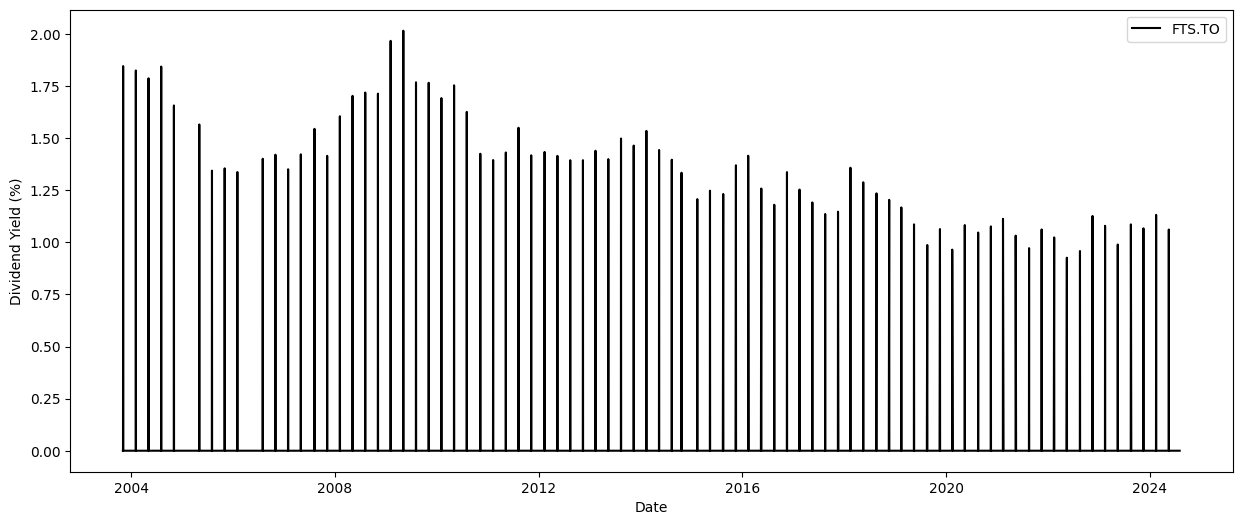

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.588893
share_price      1.000000
Name: share_price, dtype: float64


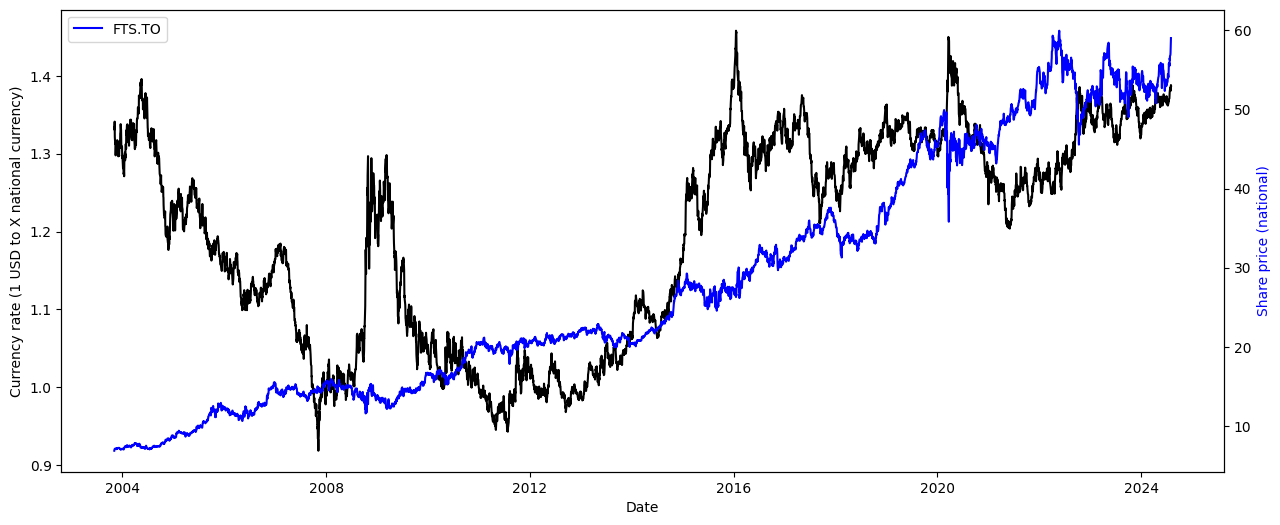

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

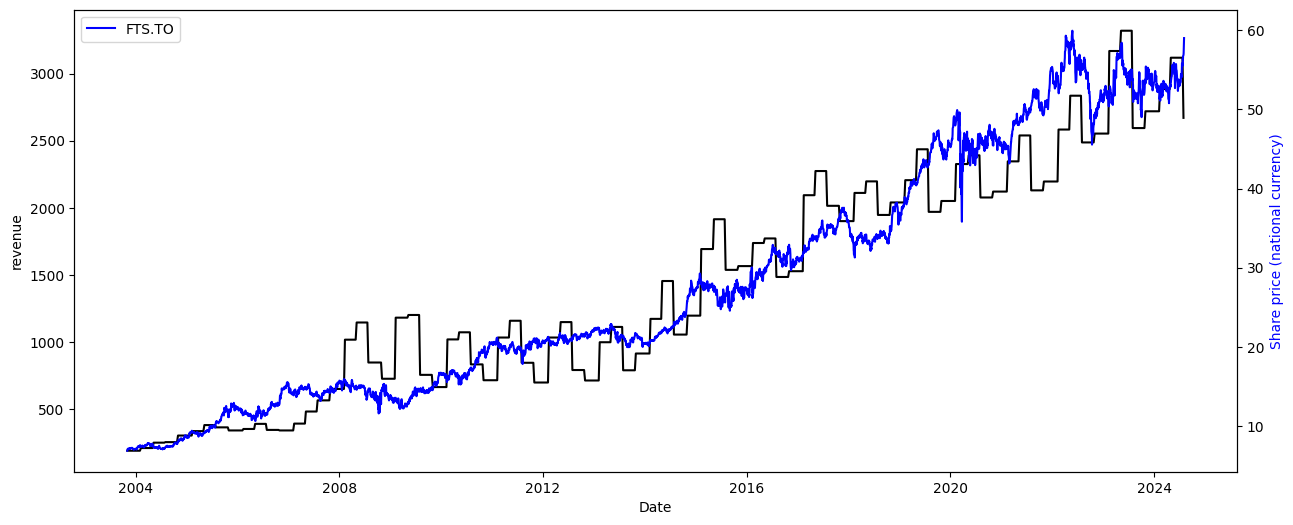

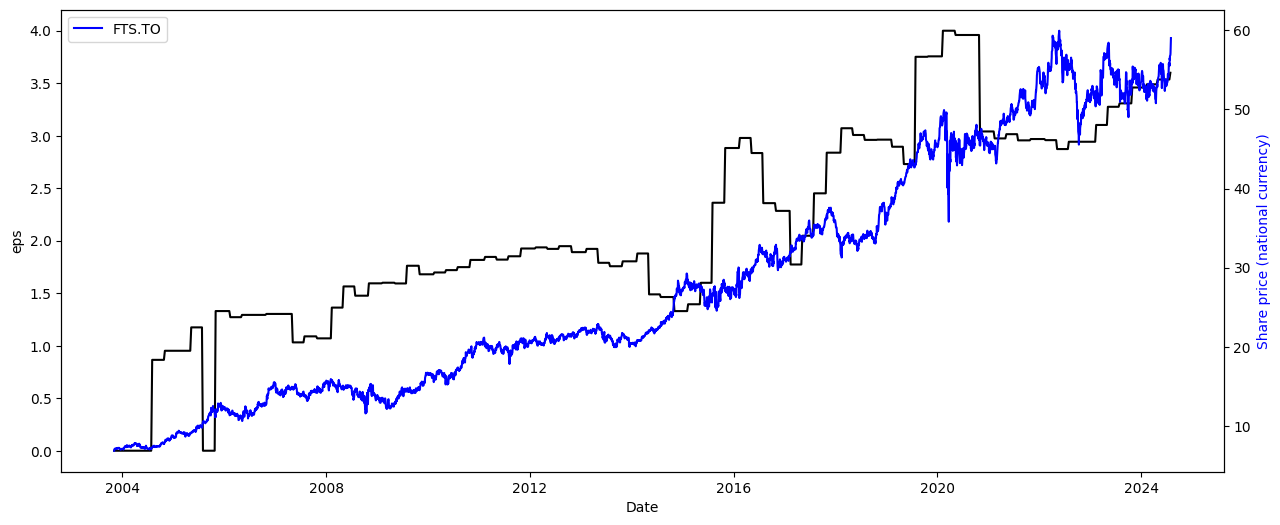

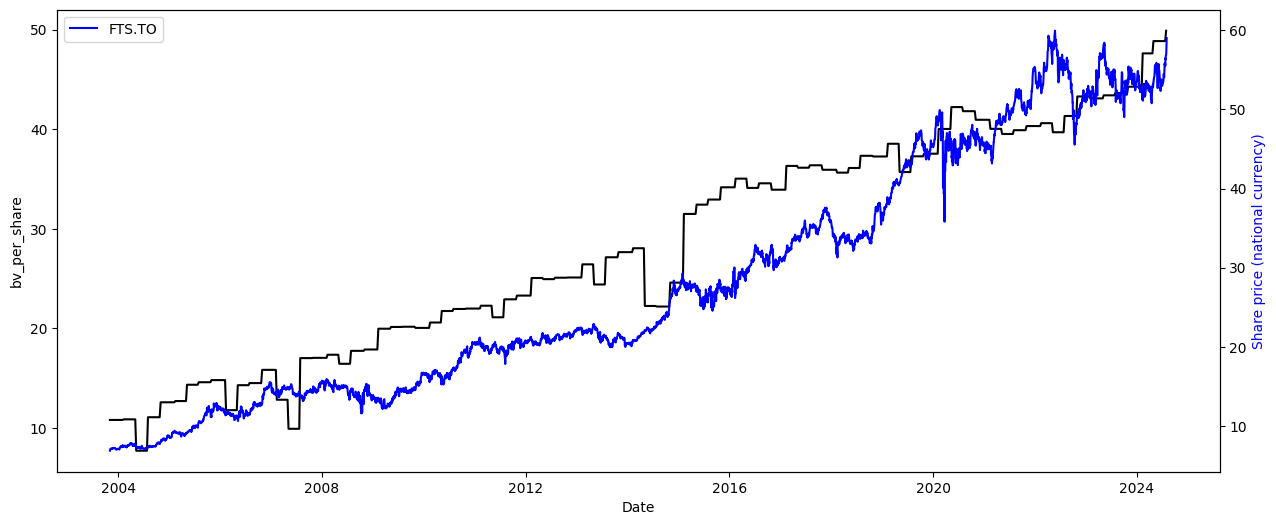

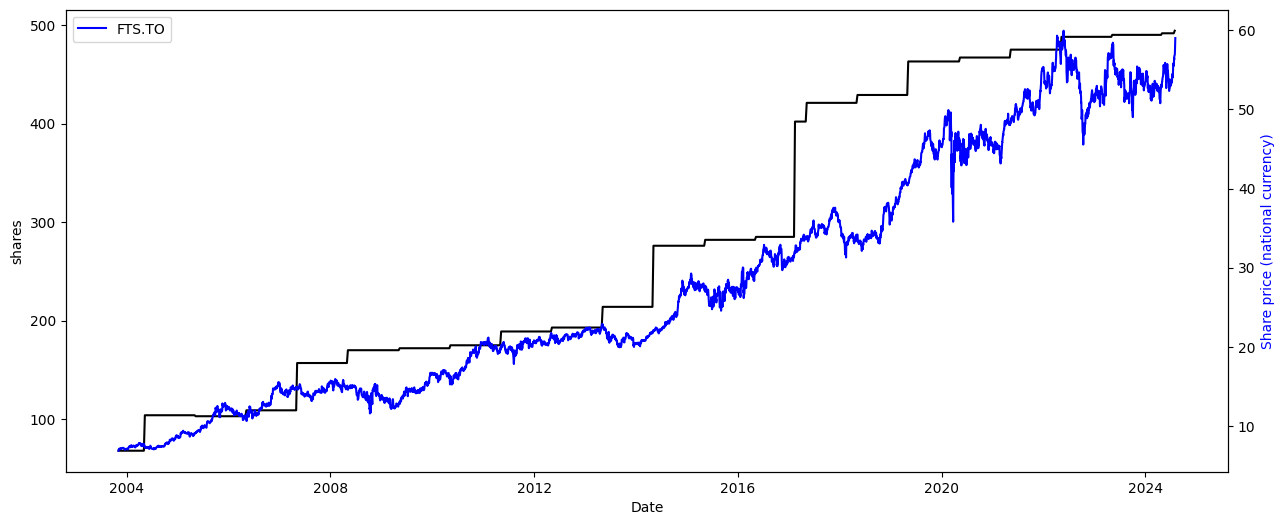

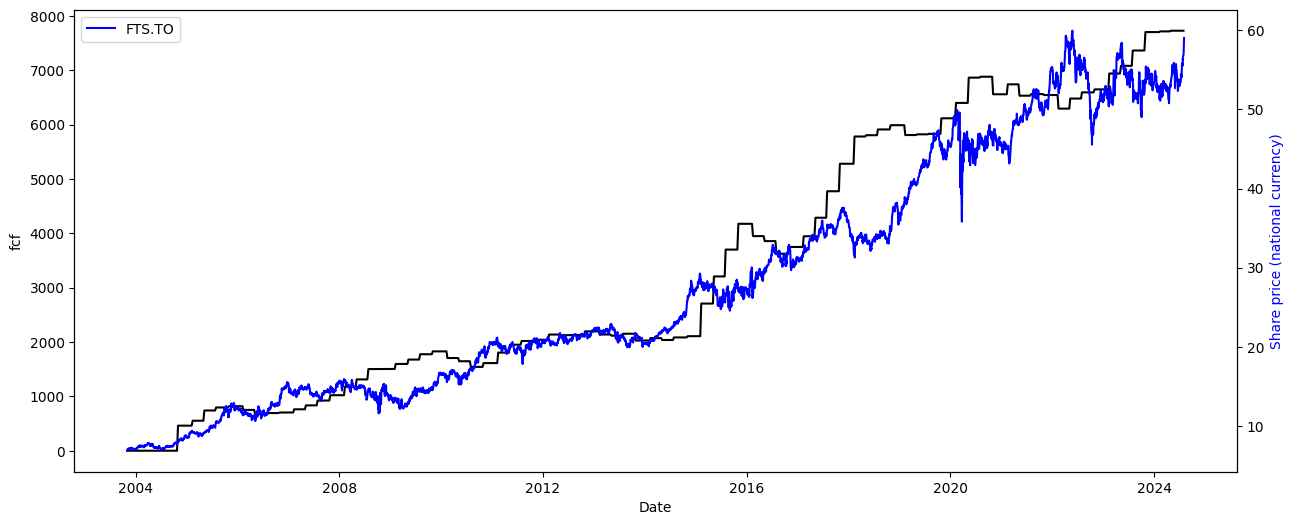

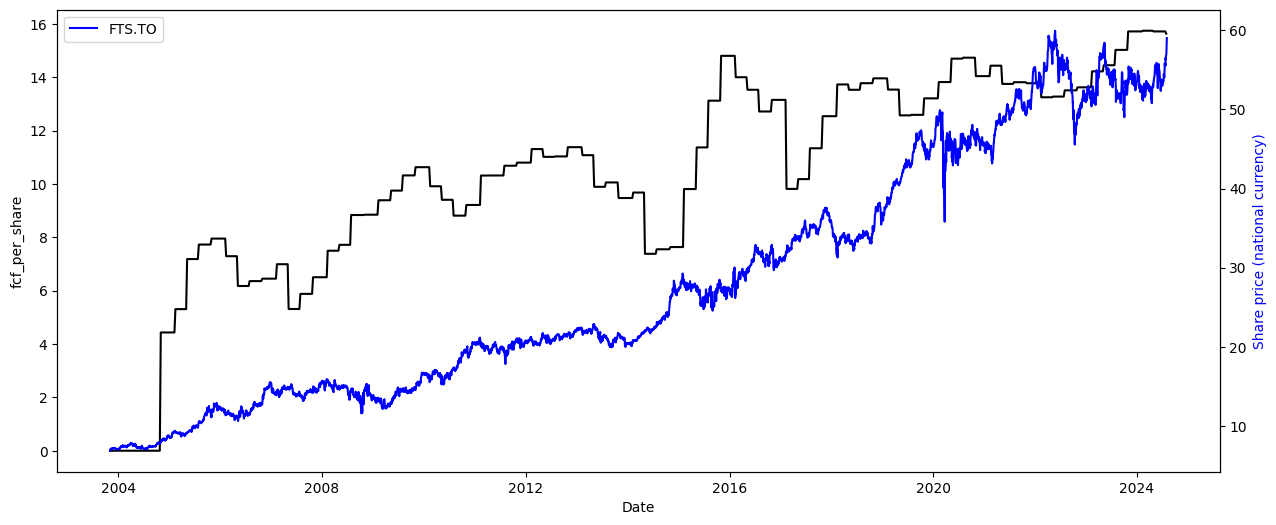

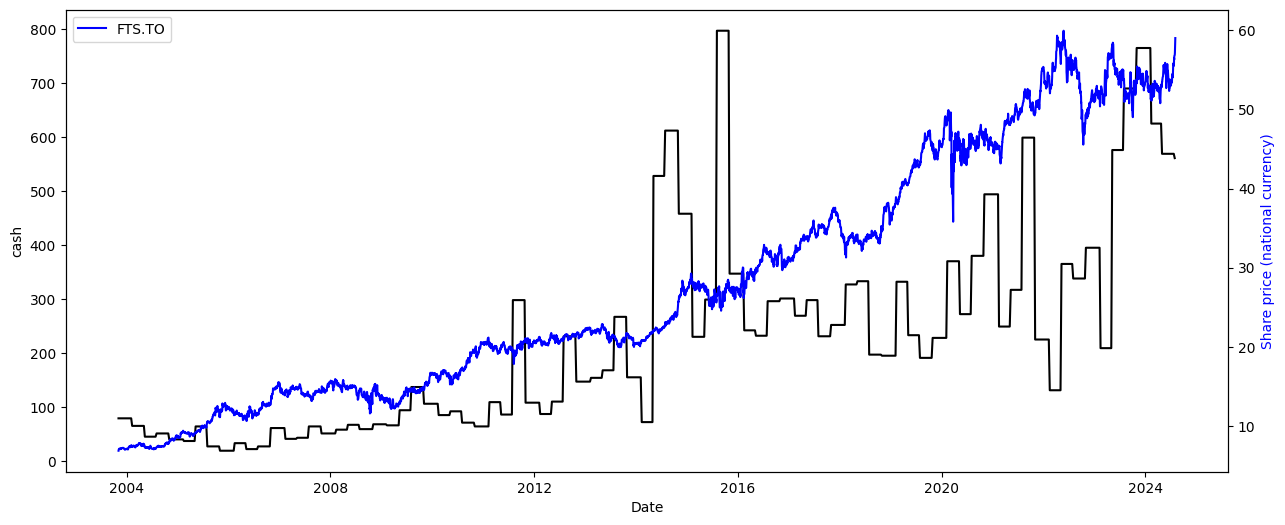

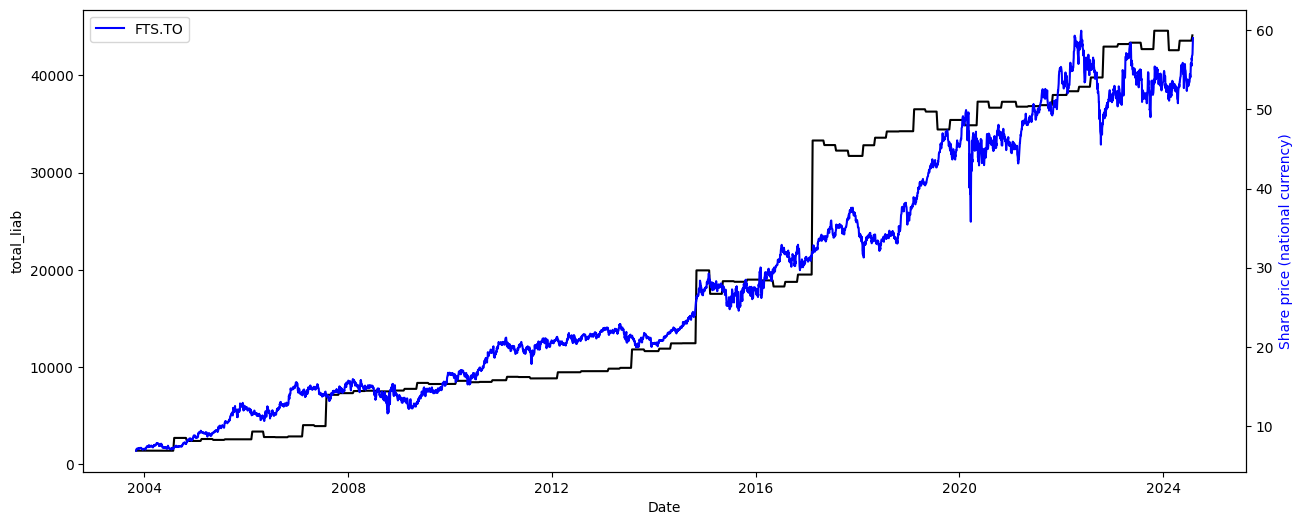

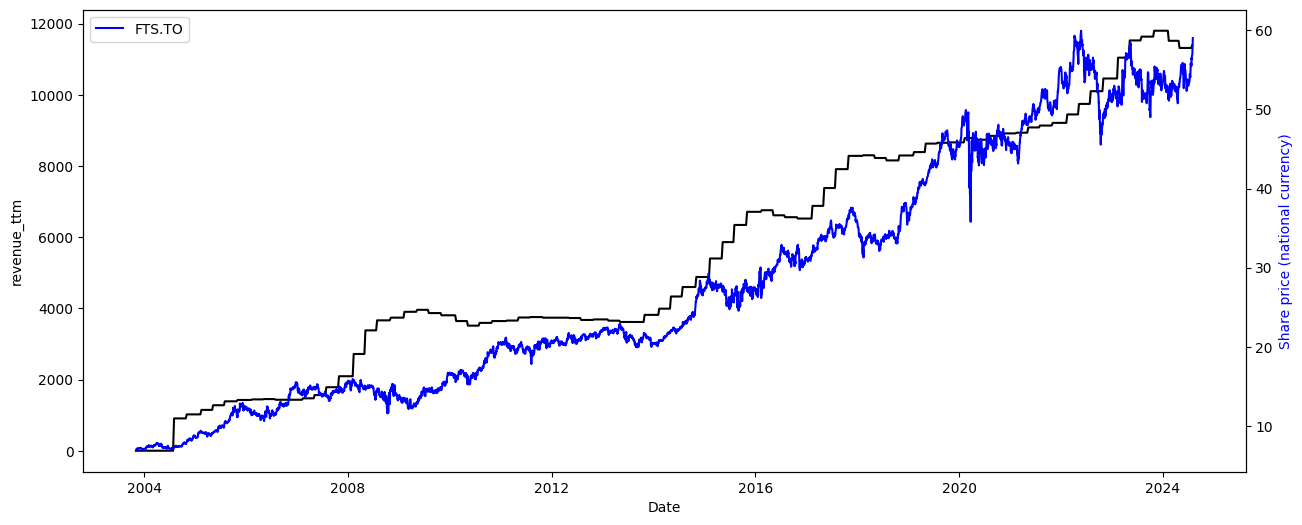

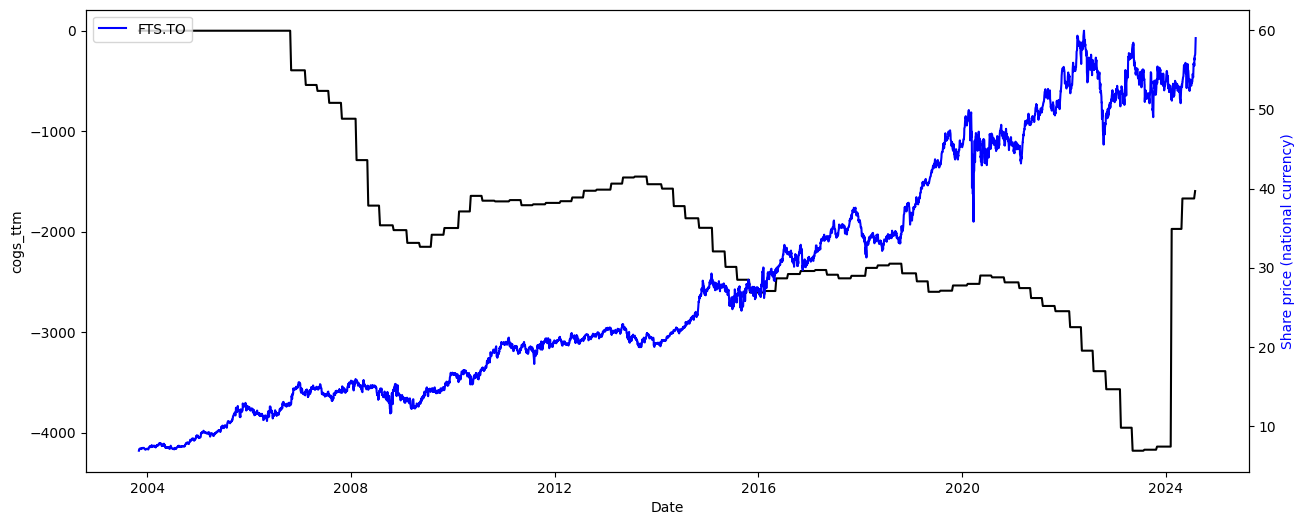

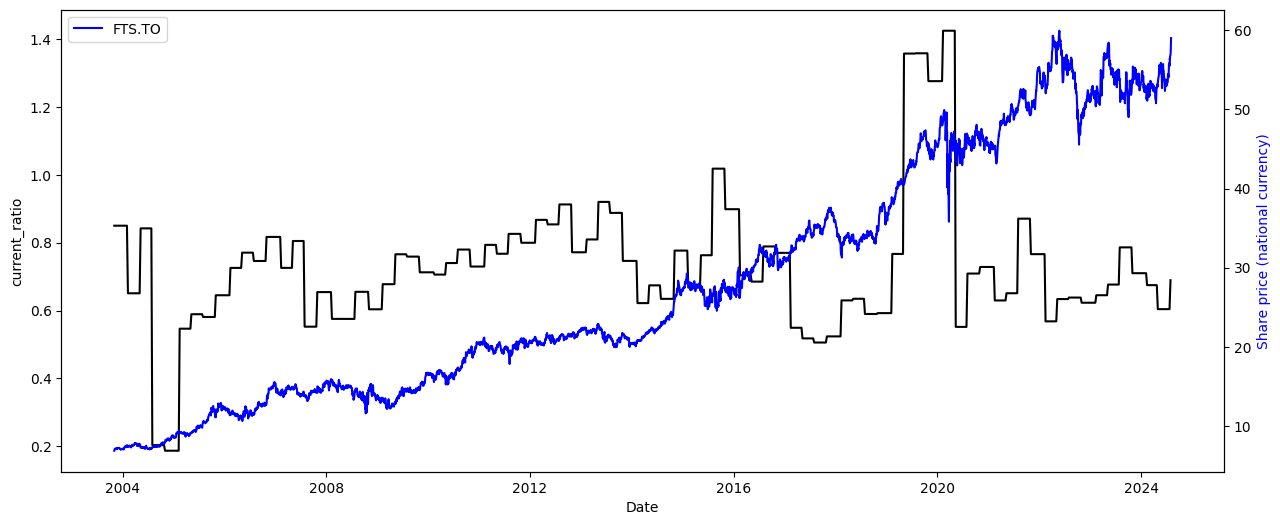

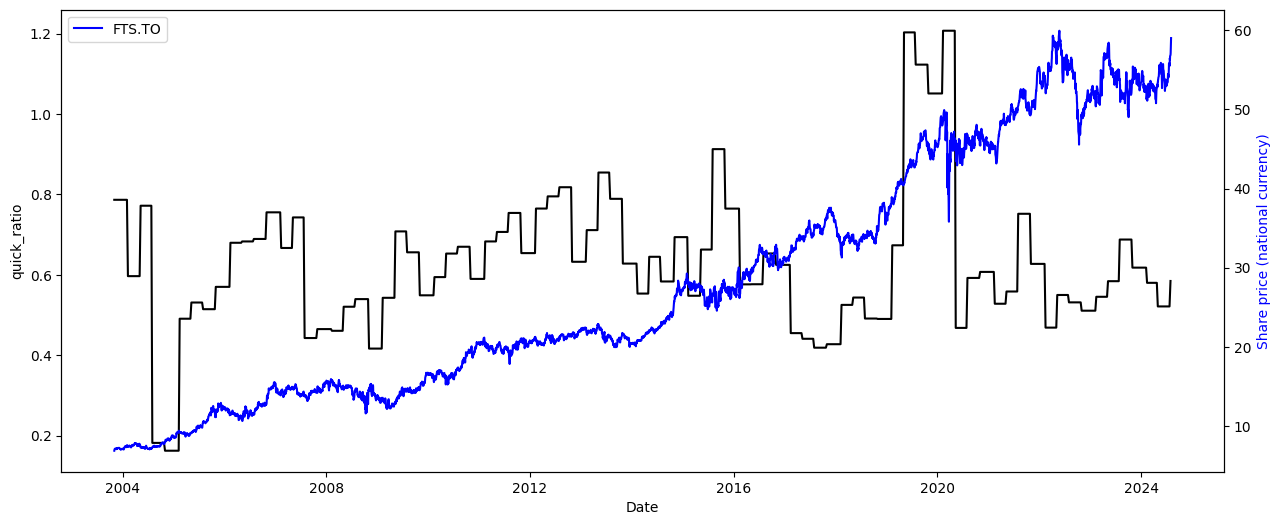

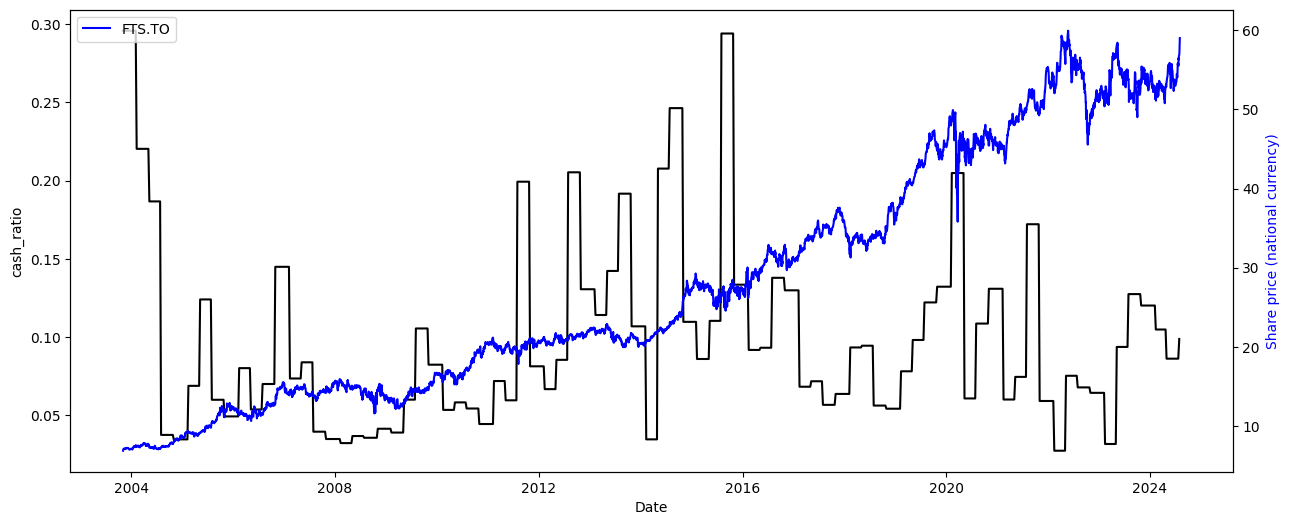

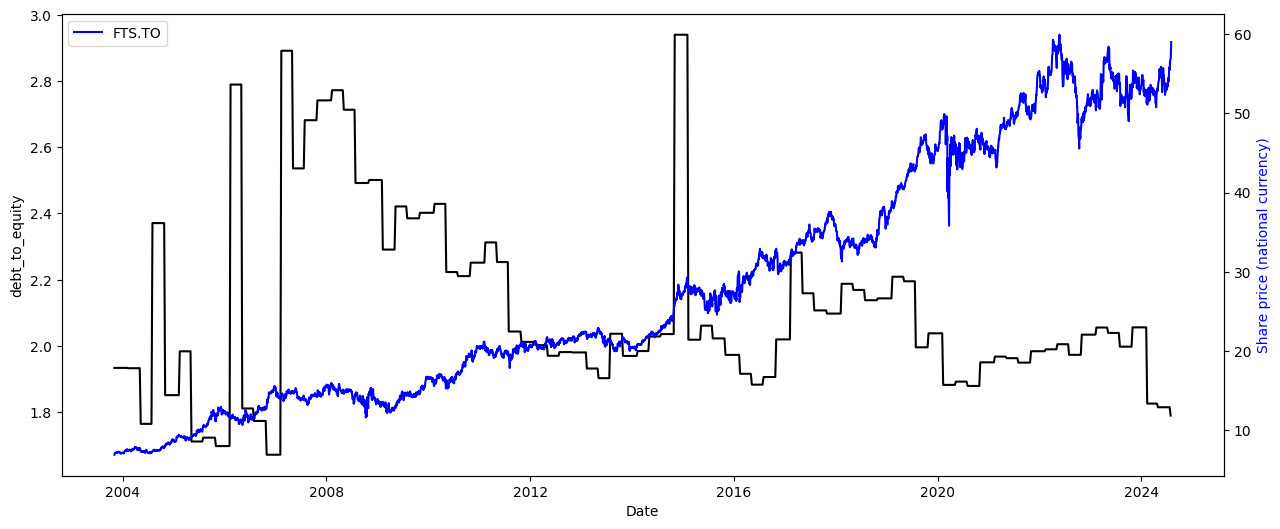

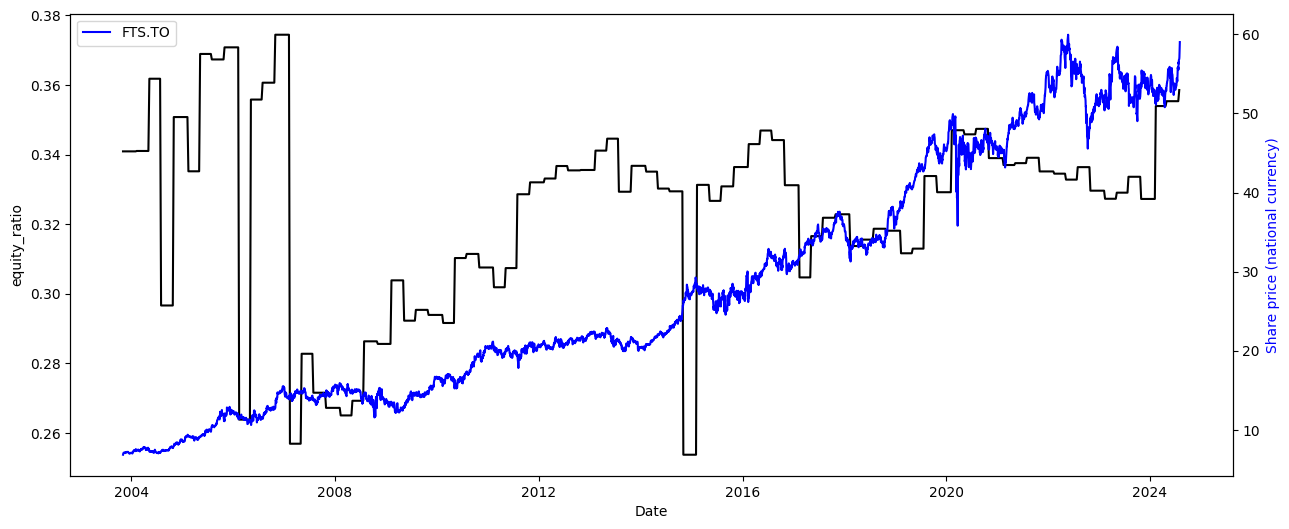

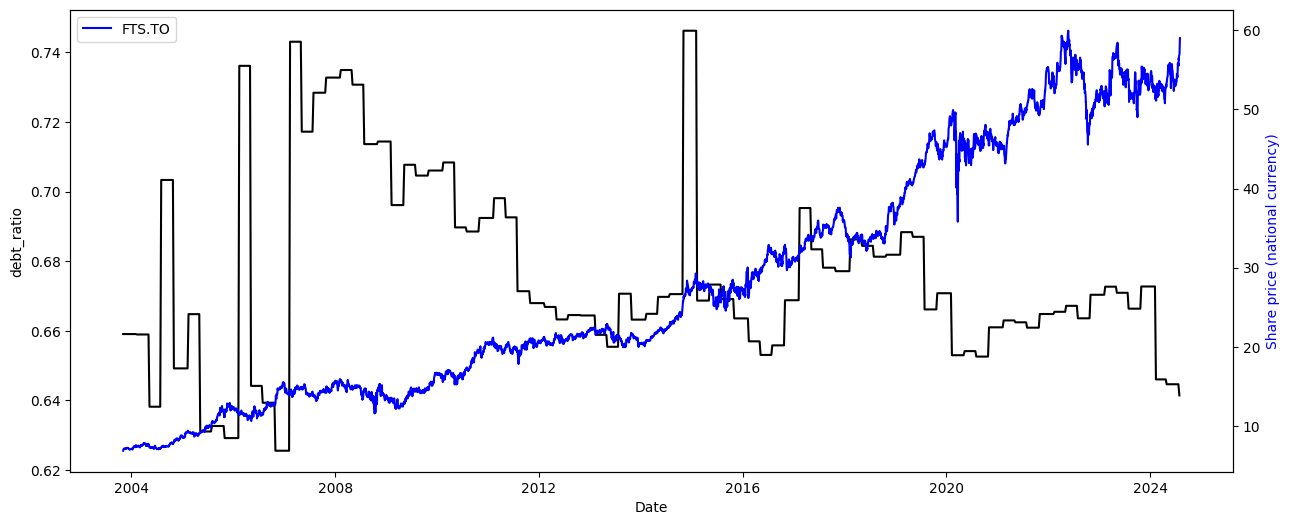

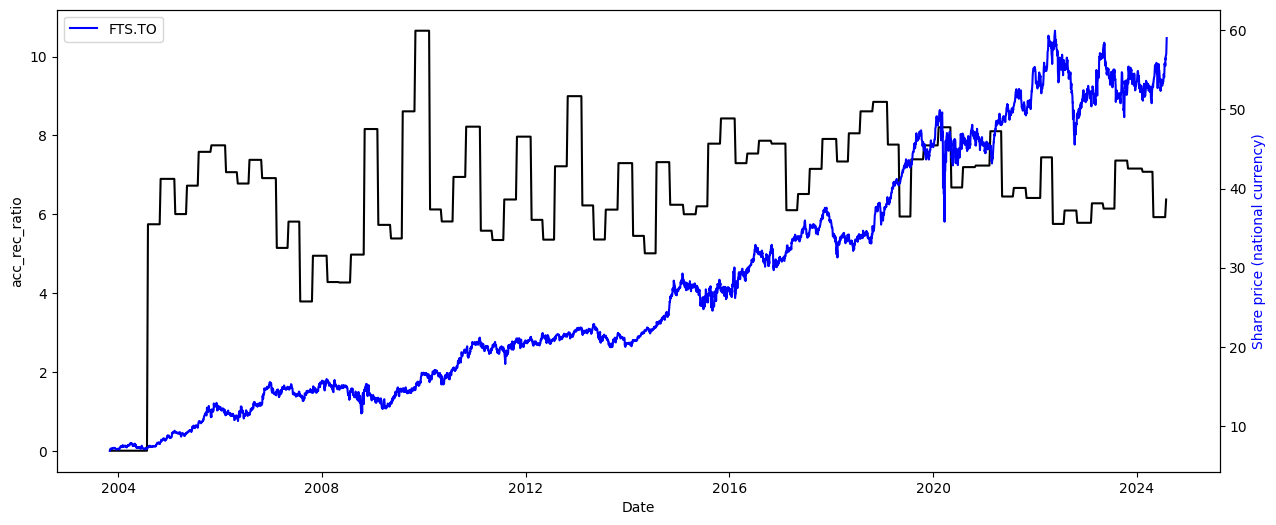

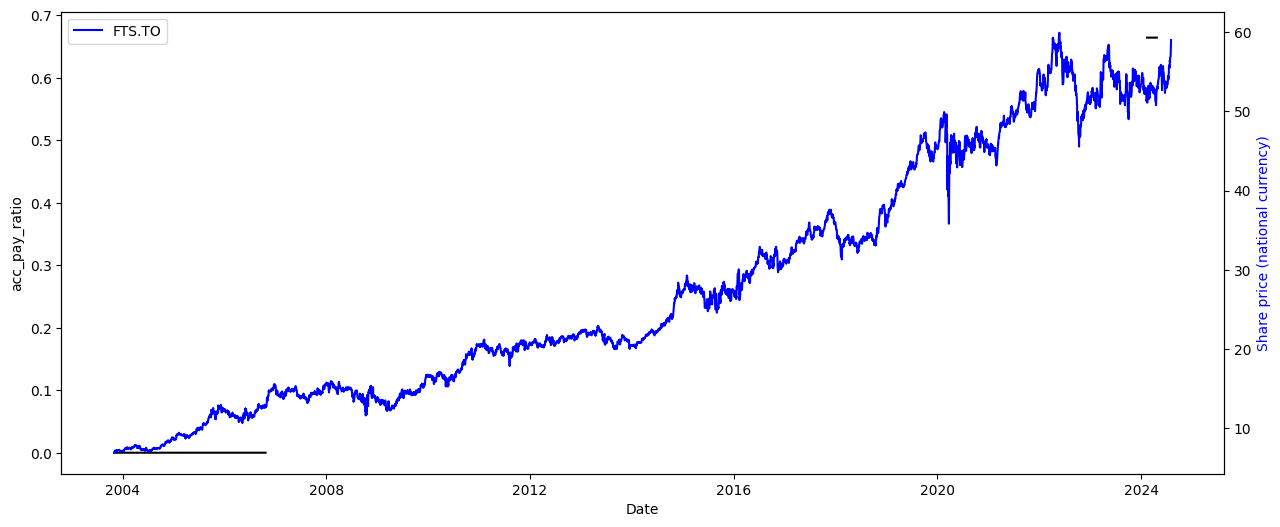

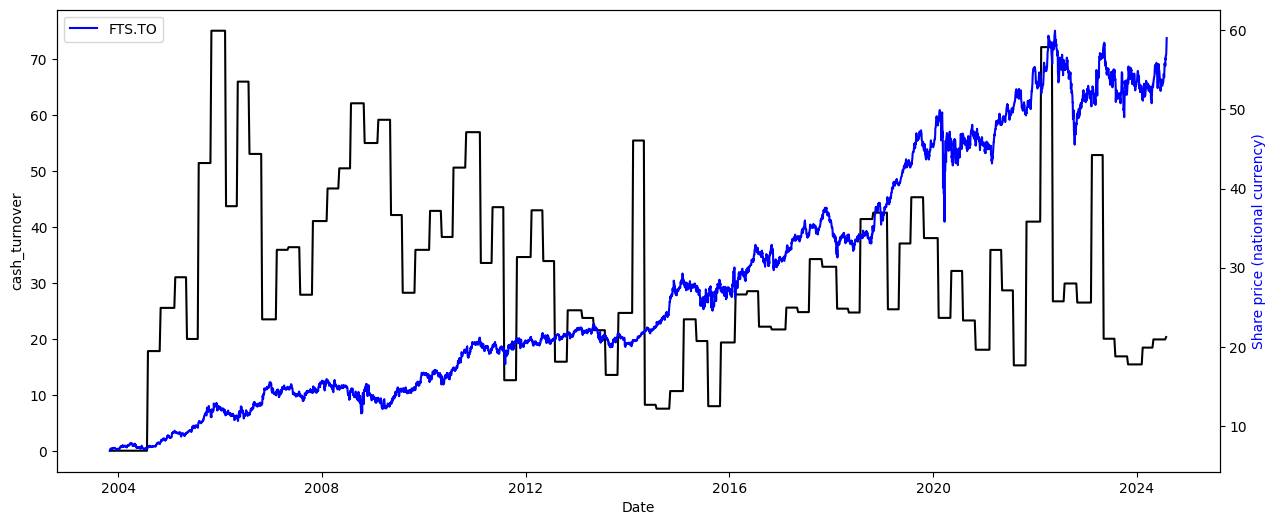

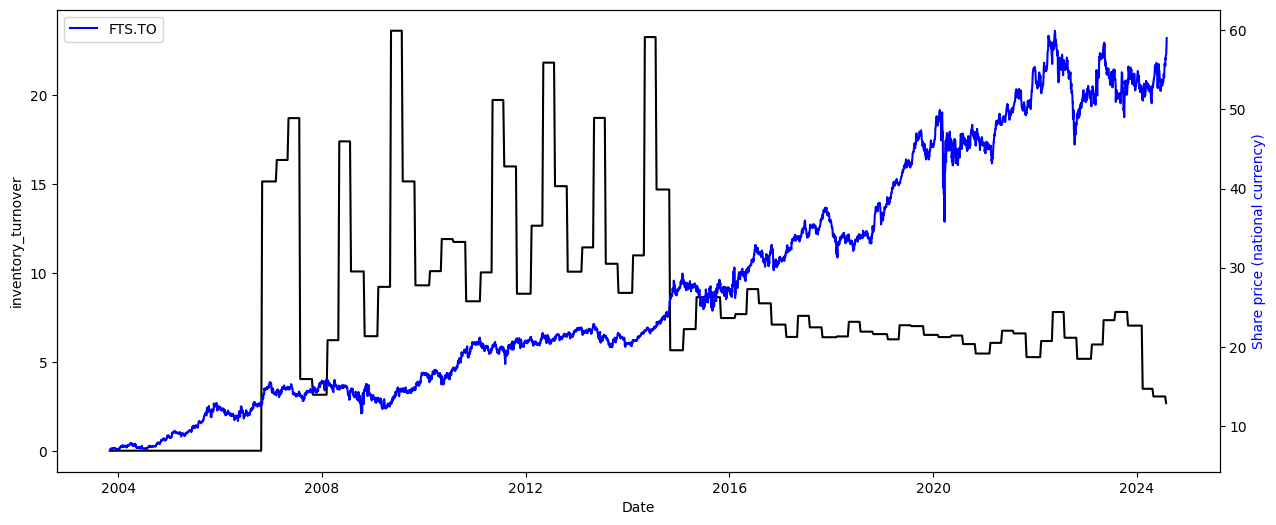

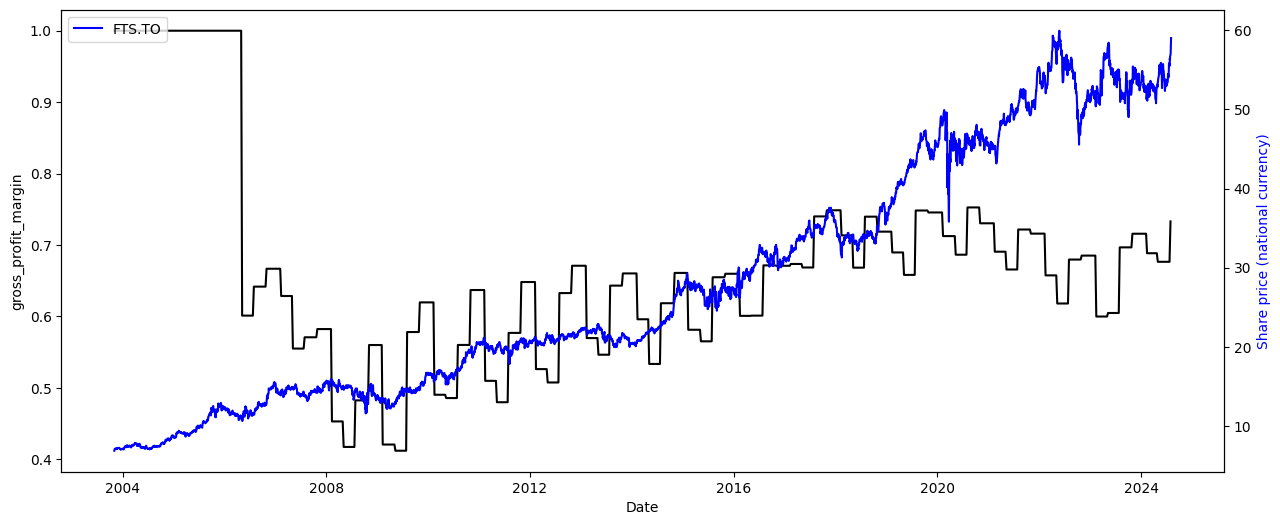

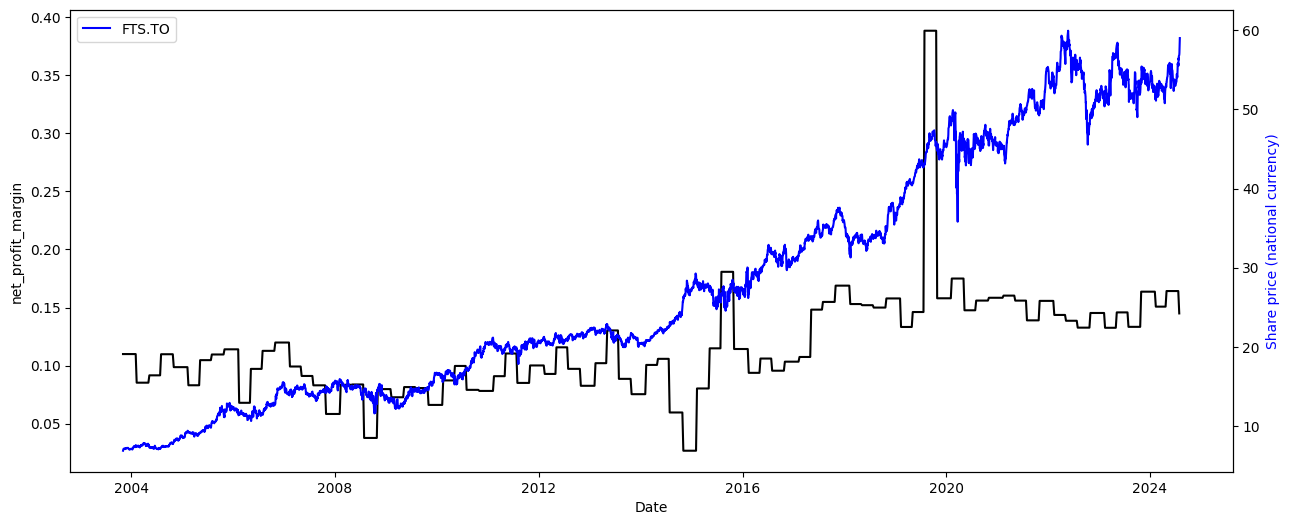

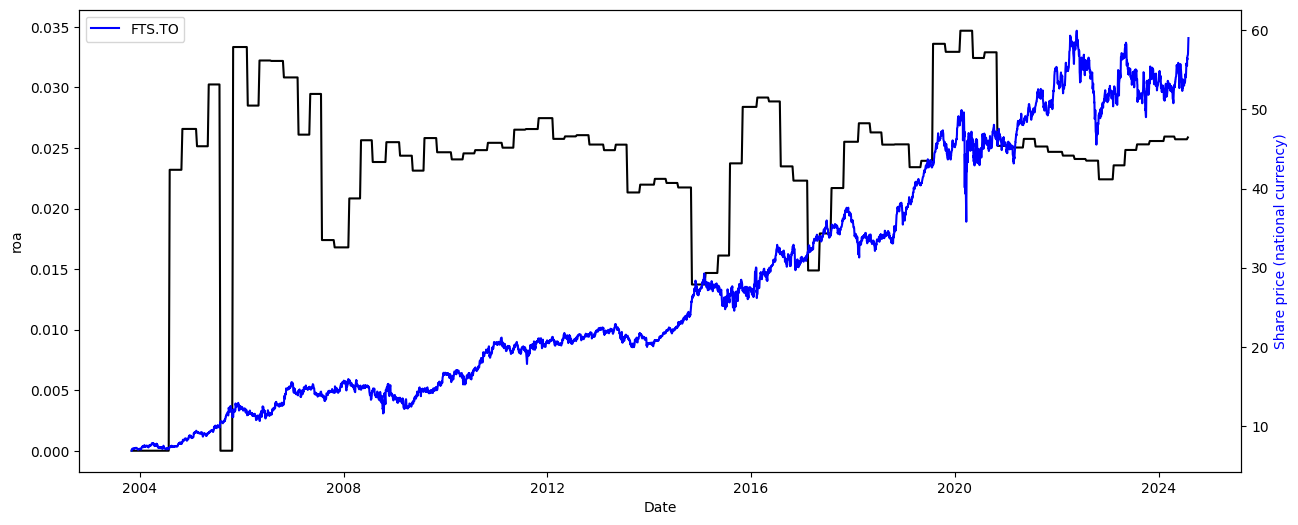

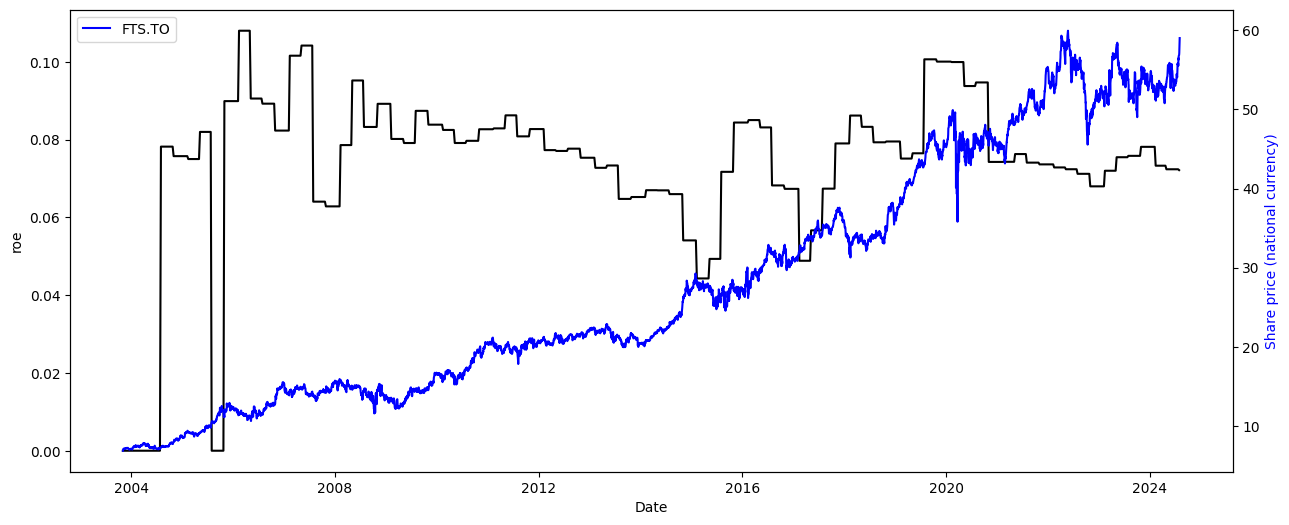

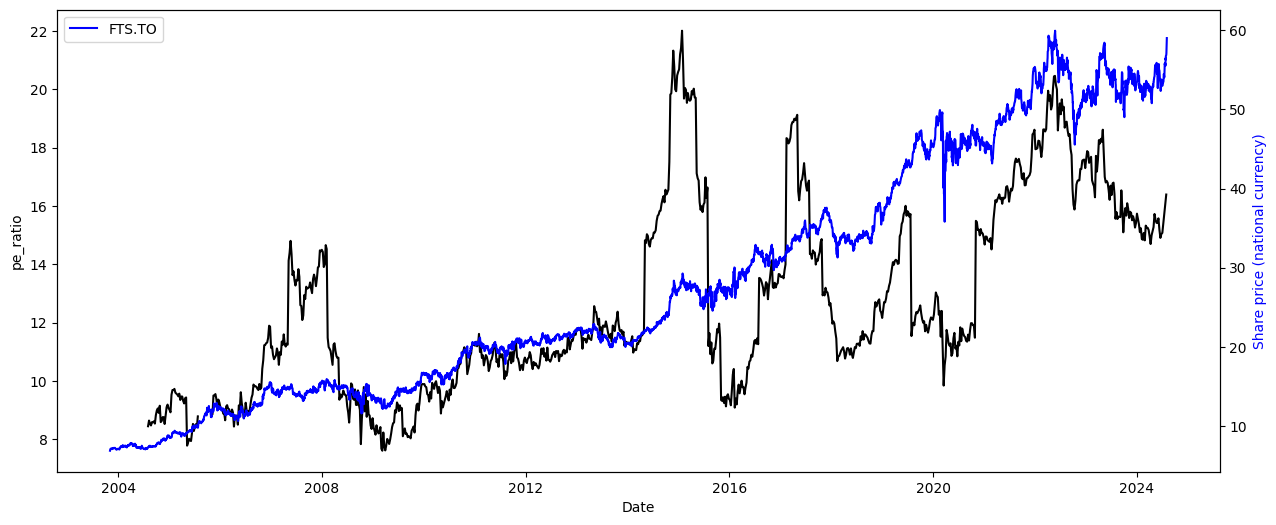

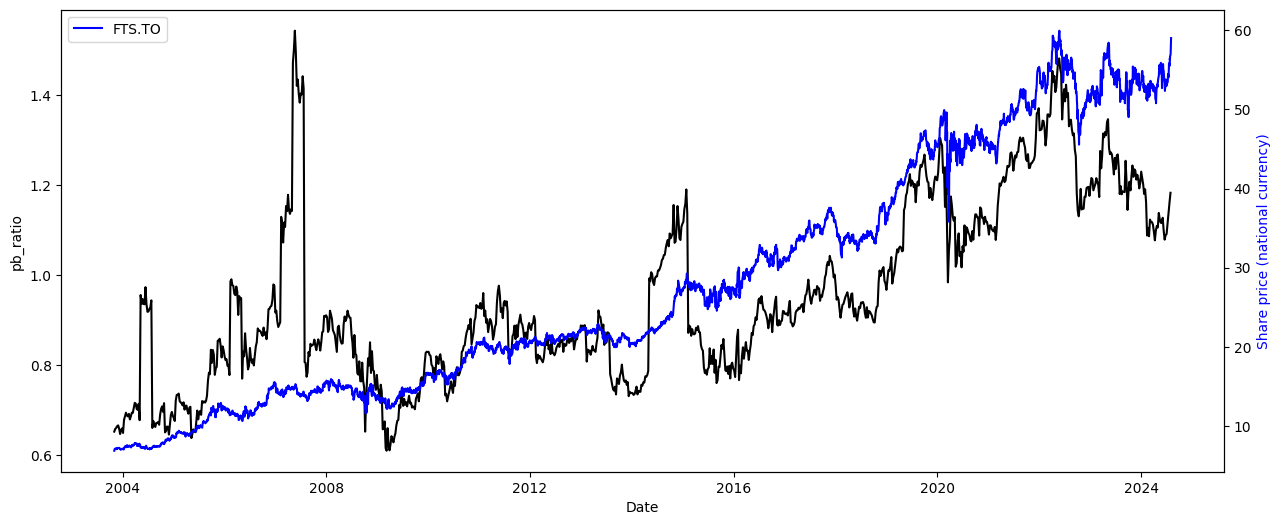

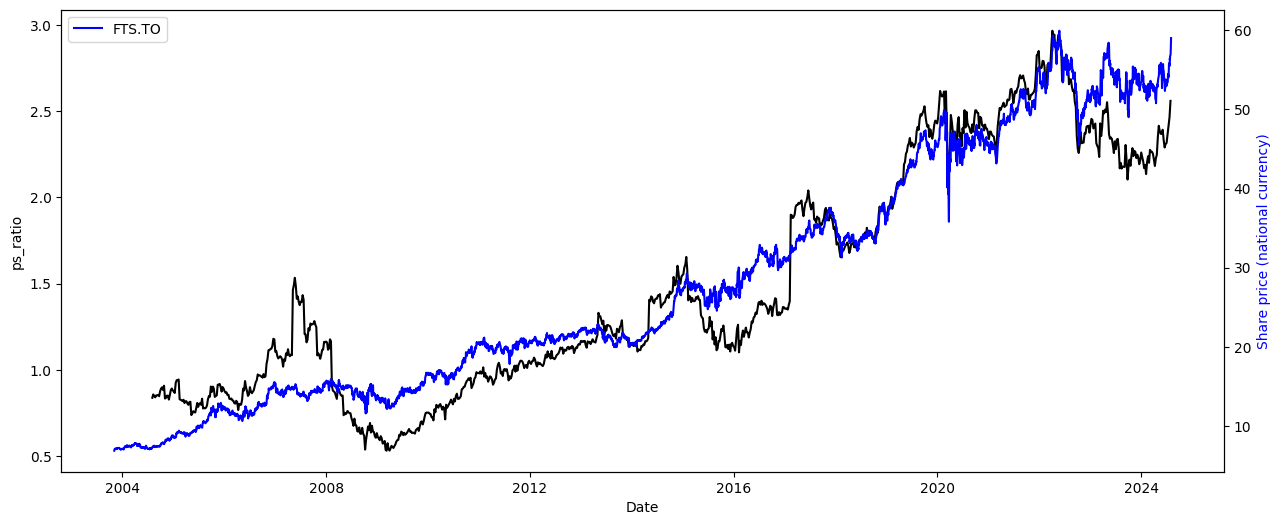

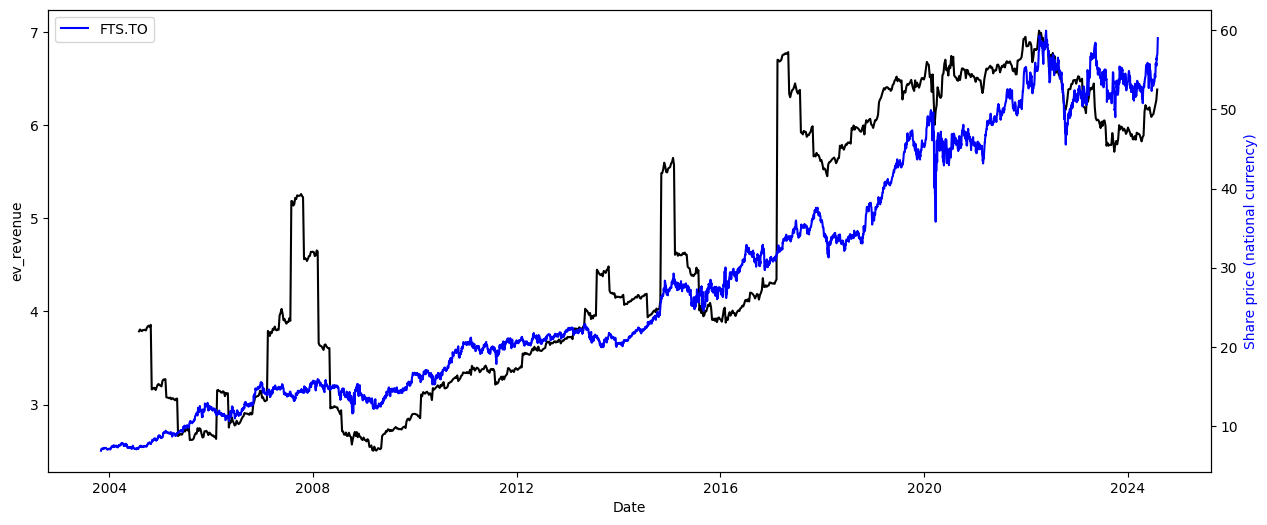

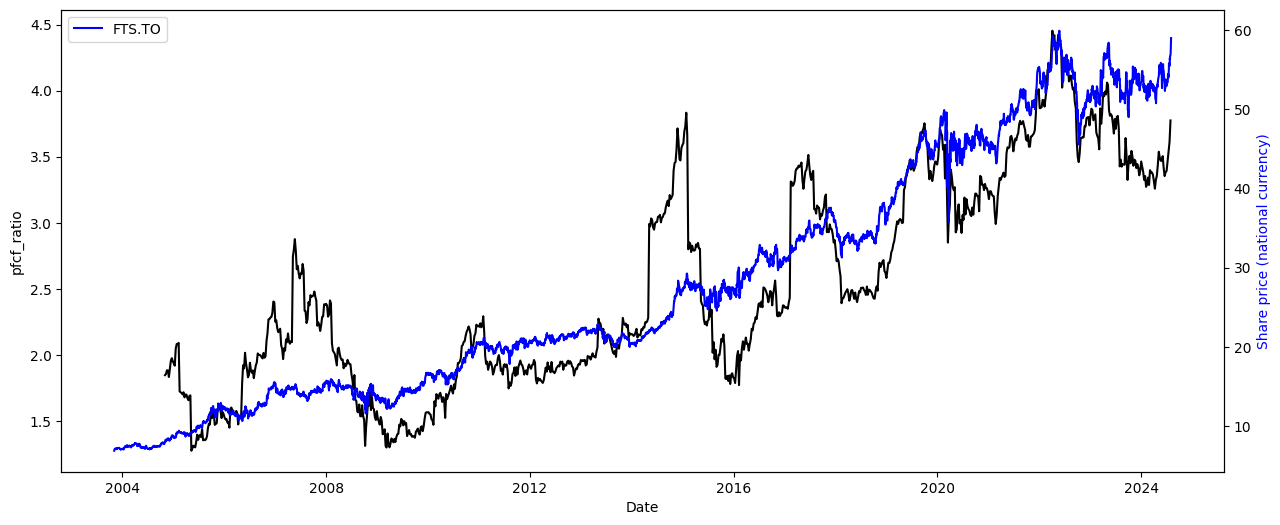

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

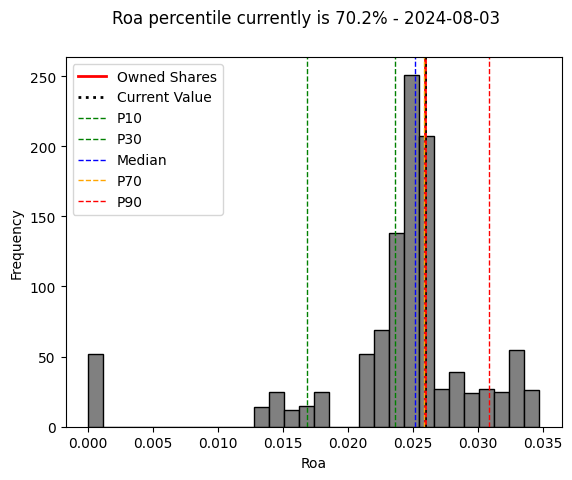

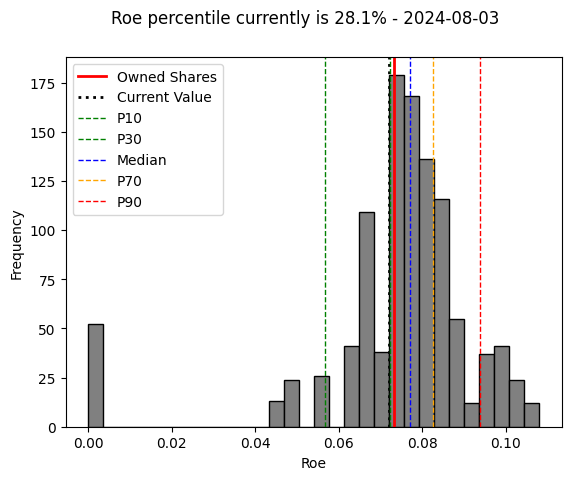

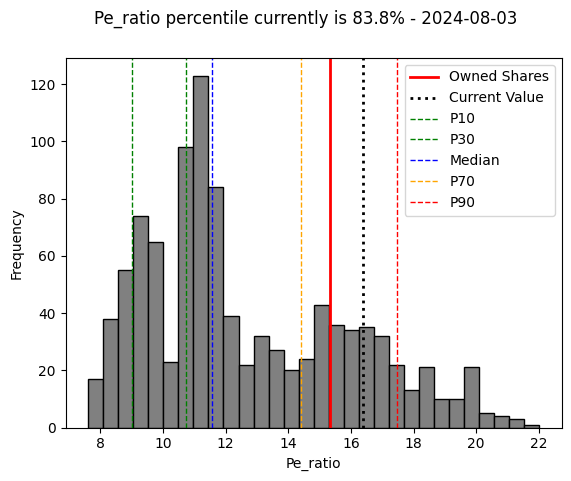

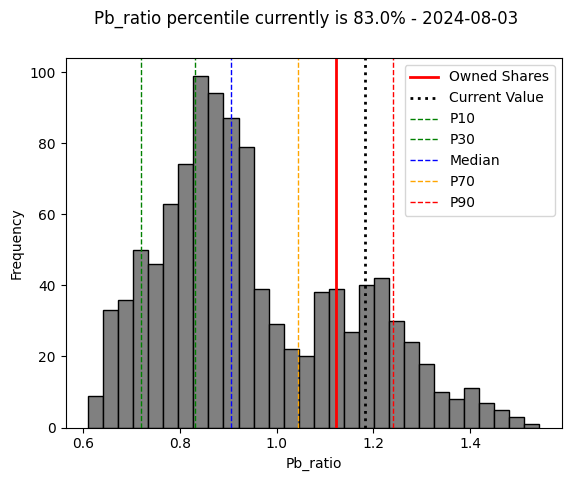

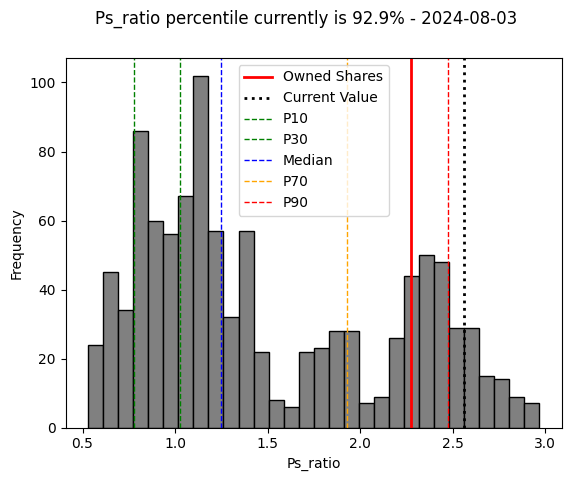

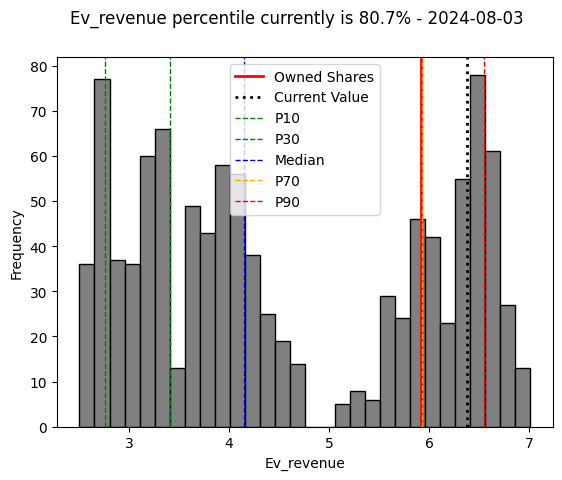

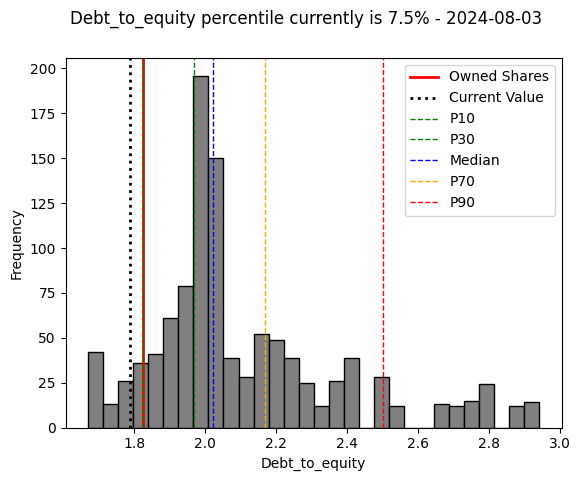

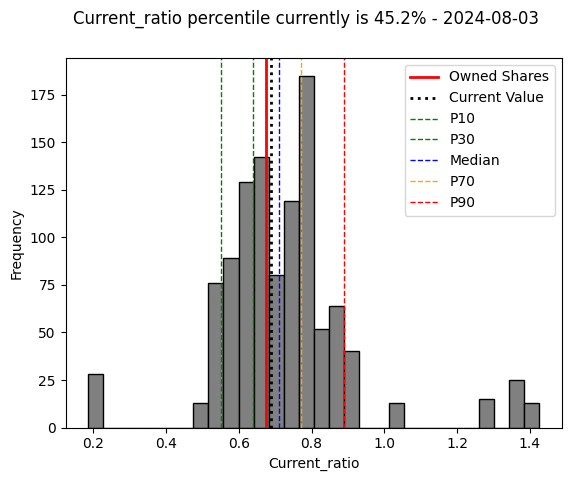

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.948784,-0.501703,0.238392,0.111121,-0.004026,-0.094034,0.195969
roe,0.948784,1.000000,-0.599535,0.224279,-0.028788,-0.092861,0.212879,0.159691
pe_ratio,-0.501703,-0.599535,1.000000,0.731513,0.745472,0.746760,-0.062399,-0.006389
pb_ratio,0.238392,0.224279,0.731513,1.000000,0.865330,0.769519,-0.039918,0.228110
ps_ratio,0.111121,-0.028788,0.745472,0.865330,1.000000,0.961005,-0.301999,0.178729
ev_revenue,-0.004026,-0.092861,0.746760,0.769519,0.961005,1.000000,-0.155821,0.116549
debt_to_equity,-0.094034,0.212879,-0.062399,-0.039918,-0.301999,-0.155821,1.000000,-0.122024
current_ratio,0.195969,0.159691,-0.006389,0.228110,0.178729,0.116549,-0.122024,1.000000


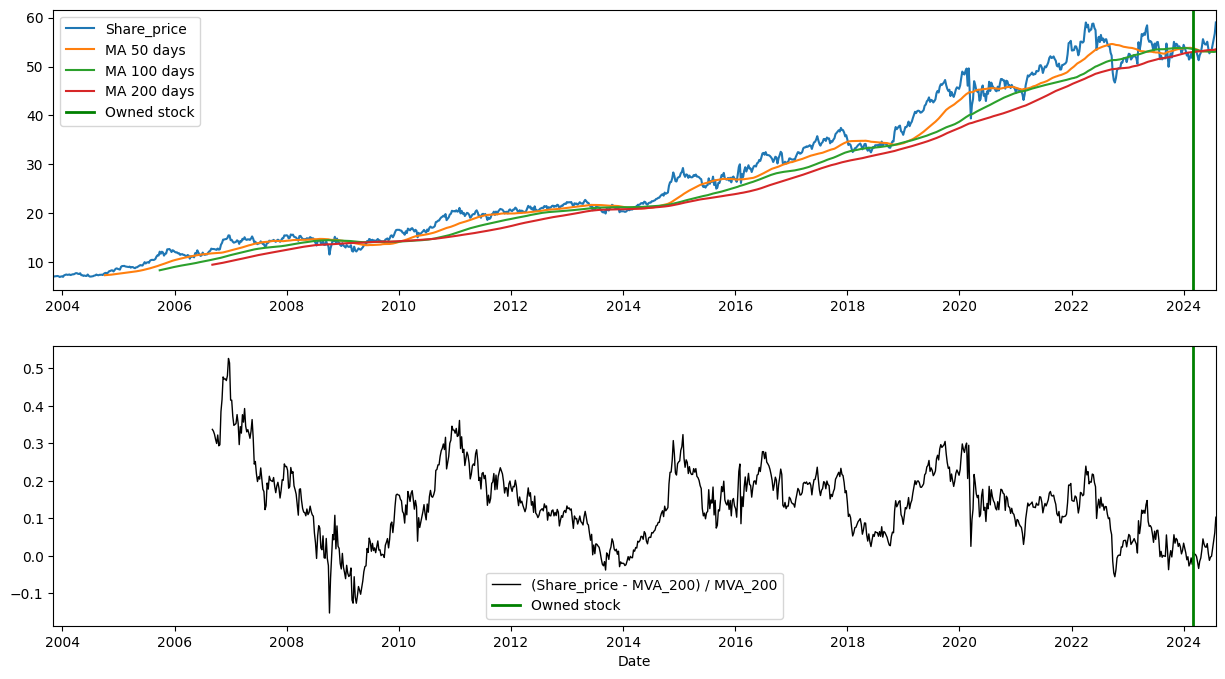

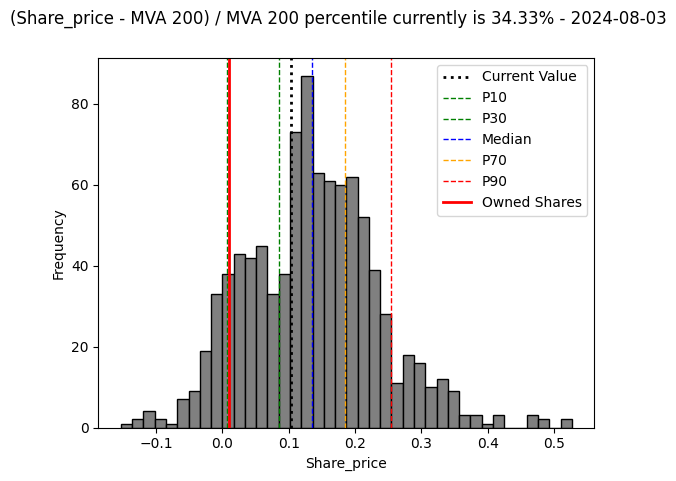

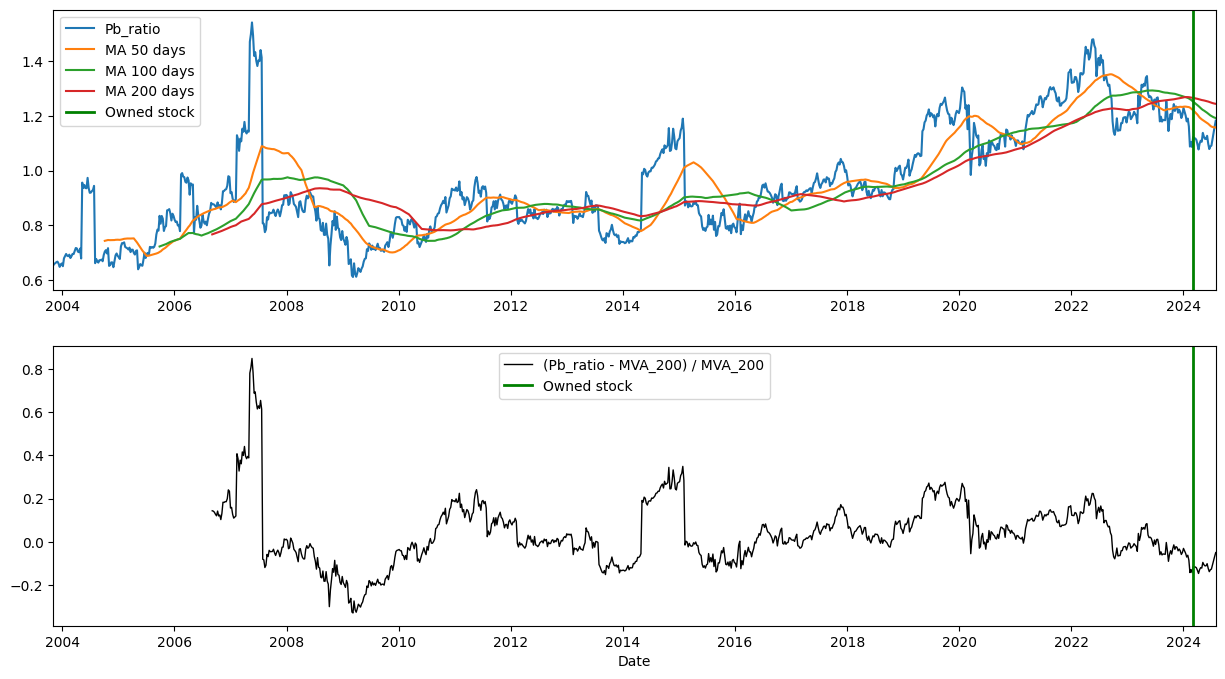

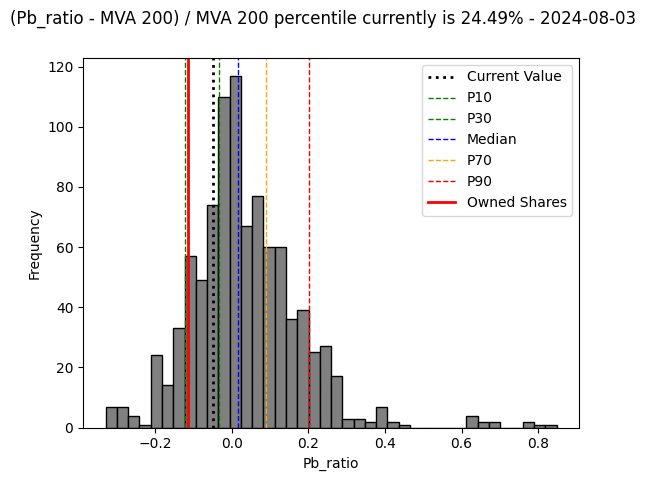

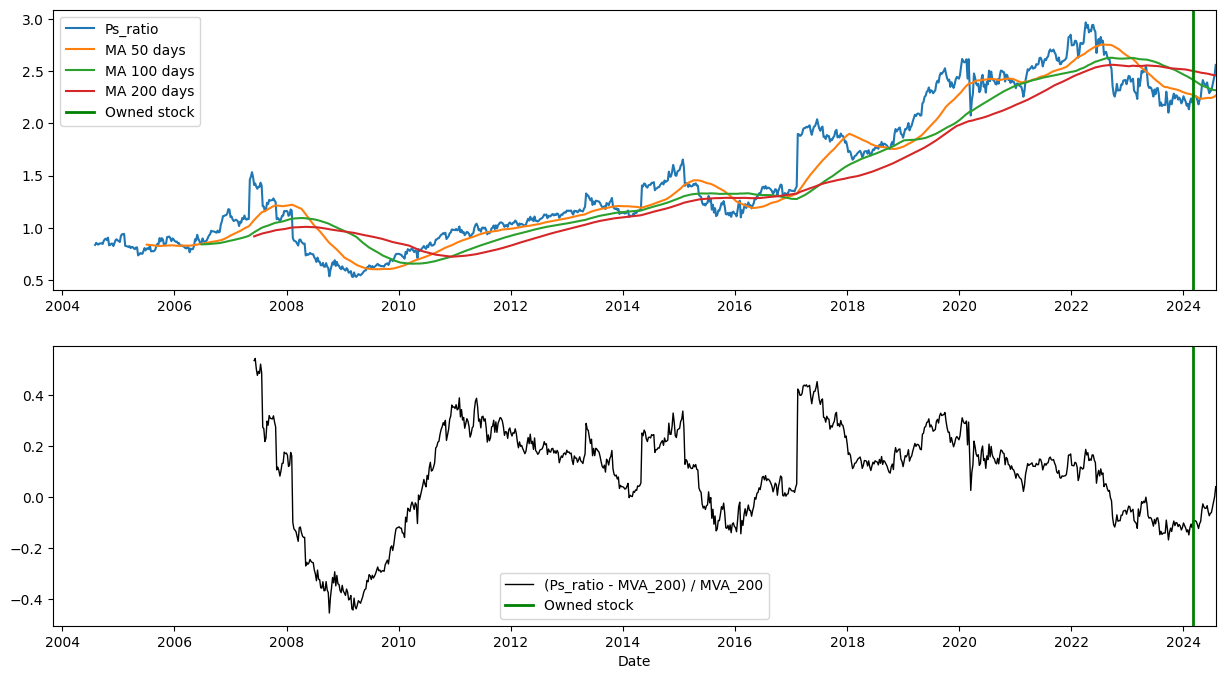

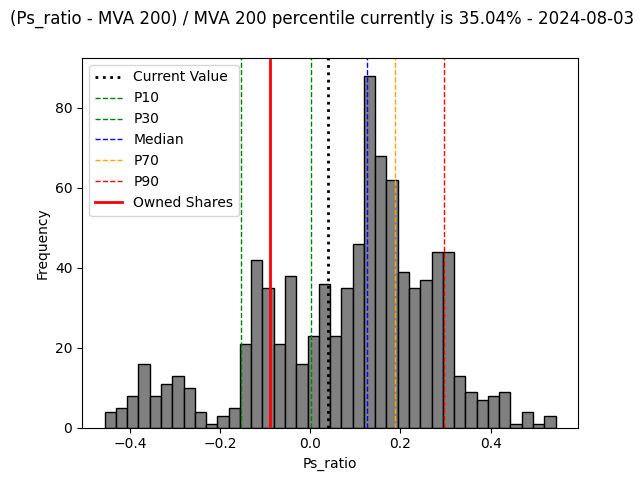

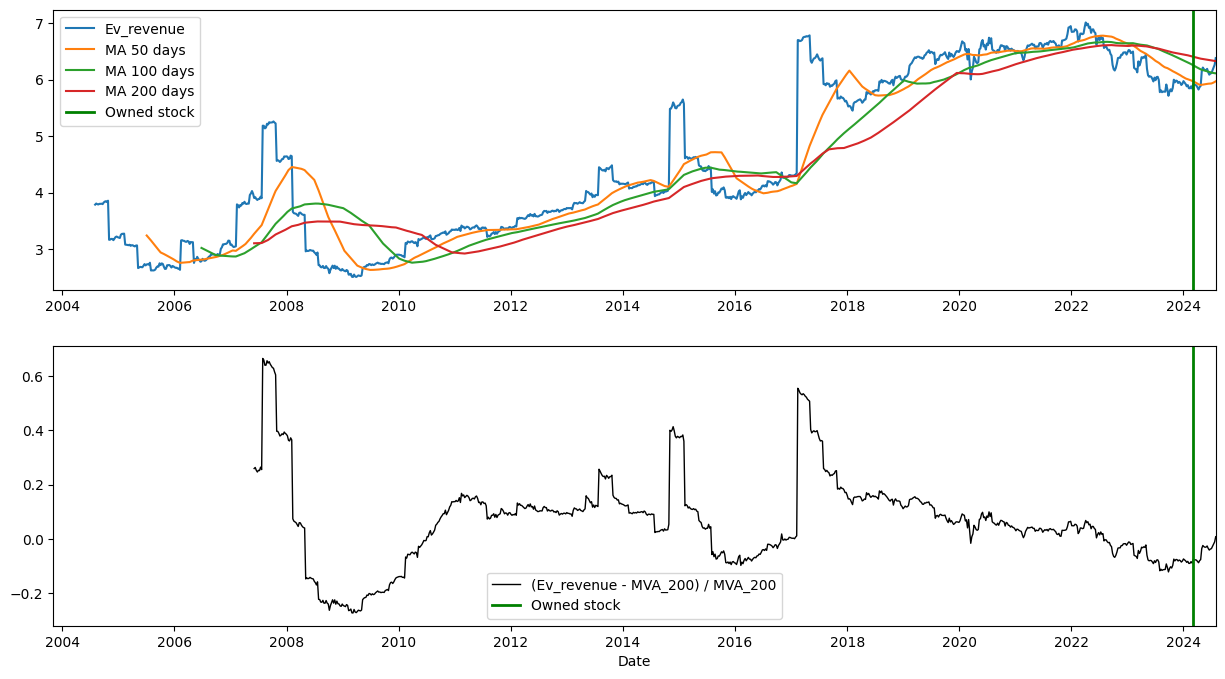

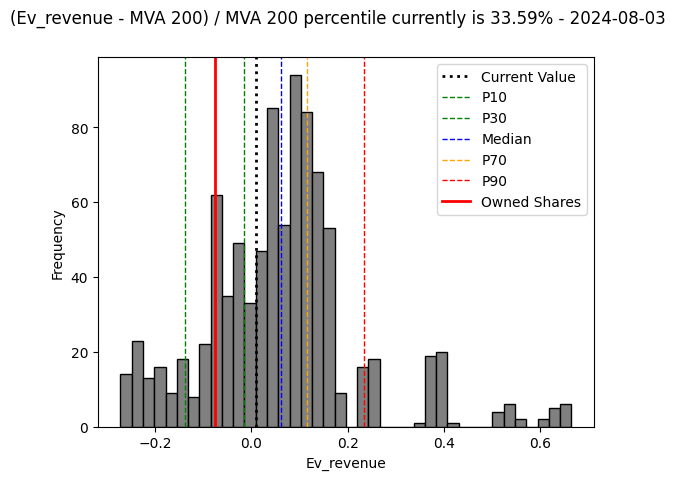

In [21]:
final_df = utils.utility_evaluation(
    input_df=merged_nat_curr,
    owned_shares=owned_shares)

In [22]:
final_df.to_csv('../test_countries/test.csv')